In [ ]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/sachchitkunichetty/rvf10k")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: arjunkawle
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sachchitkunichetty/rvf10k


100%|██████████| 273M/273M [00:06<00:00, 46.6MB/s]

In [ ]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from tqdm import tqdm
import torch.optim as optim
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torchvision import models # import pretrained models in PyTorch library
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from torchvision.datasets import ImageFolder
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac


In [ ]:
# transformations
from torchvision.transforms import transforms

custom_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])

])

In [ ]:
class RealVsGenDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [ ]:
dataset = RealVsGenDataset(
    data_dir='/content/rvf10k/rvf10k/train'
)

In [ ]:
len(dataset)


7000

In [ ]:
data_dir = '/content/rvf10k/rvf10k/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'fake', 1: 'real'}


In [ ]:
train_folder = '/content/rvf10k/rvf10k/train'
test_folder = '/content/rvf10k/rvf10k/valid'

train_dataset = RealVsGenDataset(train_folder, transform=custom_transform)
test_dataset =RealVsGenDataset(test_folder, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,pin_memory=True)


In [ ]:
print("Train classes:", train_dataset.data.classes)
print("Train class_to_idx:", train_dataset.data.class_to_idx)

print("Test classes:", test_dataset.data.classes)
print("Test class_to_idx:", test_dataset.data.class_to_idx)


Train classes: ['fake', 'real']
Train class_to_idx: {'fake': 0, 'real': 1}
Test classes: ['fake', 'real']
Test class_to_idx: {'fake': 0, 'real': 1}


In [ ]:
vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:08<00:00, 63.1MB/s]


In [ ]:
for param in vgg16.features.parameters():
  param.requires_grad=False

In [ ]:
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)
)

In [ ]:
vgg16 = vgg16.to(device)

In [ ]:
learning_rate = 0.0001
epochs = 10


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=learning_rate)

In [ ]:
print("Torch CUDA available:", torch.cuda.is_available())
print("Device in use:", torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

Torch CUDA available: True
Device in use: cuda:0
GPU Name: Tesla T4


In [ ]:
from tqdm import tqdm
import torch

def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs=20, patience=5, tolerance=0.05, device="cuda"):
    """
    Training loop with validation, early stopping (tolerance-based),
    and tracking metrics.

    Args:
        model: PyTorch model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        criterion: loss function
        optimizer: optimizer
        num_epochs: max number of epochs
        patience: early stopping patience
        tolerance: acceptable % tolerance for validation loss (e.g. 0.05 = 5%)
        device: "cuda" or "cpu"
    """
    best_val_loss = float("inf")
    patience_counter = 0

    # Lists to store metrics for plotting
    val_losses = []
    val_accuracies = []
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        # -------------------- TRAIN --------------------
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for batch_features, batch_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_features.size(0)
            _, predicted = torch.max(outputs, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # -------------------- VALIDATION --------------------
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for batch_features, batch_labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)

                val_loss += loss.item() * batch_features.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += batch_labels.size(0)
                val_correct += (predicted == batch_labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # -------------------- EARLY STOPPING (tolerance-based) --------------------
        allowed_loss = best_val_loss * (1 + tolerance)

        if val_loss <= allowed_loss:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), "best_vgg16.pth")
                print(f"✅ Best model updated! (New best val loss: {best_val_loss:.4f})")
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"⚠️ Validation loss {val_loss:.4f} exceeds tolerance "
                  f"(best {best_val_loss:.4f}, allowed {allowed_loss:.4f}) "
                  f"(patience {patience_counter}/{patience})")
            if patience_counter >= patience:
                print("⏹️ Early stopping triggered!")
                break

    # Return metrics for plotting
    return train_losses, train_accuracies, val_losses, val_accuracies


In [ ]:
# Example: assuming you already have vgg16, train_loader, test_loader, criterion, optimizer

device = "cuda" if torch.cuda.is_available() else "cpu"
vgg16.to(device)

train_losses, train_accs, val_losses, val_accs = train_model(
    model=vgg16,
    train_loader=train_loader,
    val_loader=test_loader,   # or val_loader if you have a separate one
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=20,
    patience=5,       # how many bad epochs to allow before stopping
    tolerance=0.05,   # 5% tolerance band
    device=device
)


Epoch 1/20 [Val]: 100%|██████████| 94/94 [00:23<00:00,  4.08it/s]


Epoch [1/20] | Train Loss: 0.0264, Train Acc: 98.94% | Val Loss: 0.6465, Val Acc: 86.47%
✅ Best model updated! (New best val loss: 0.6465)


Epoch 2/20 [Val]: 100%|██████████| 94/94 [00:22<00:00,  4.18it/s]


Epoch [2/20] | Train Loss: 0.0159, Train Acc: 99.50% | Val Loss: 0.6750, Val Acc: 87.17%


Epoch 3/20 [Val]: 100%|██████████| 94/94 [00:22<00:00,  4.13it/s]


Epoch [3/20] | Train Loss: 0.0182, Train Acc: 99.46% | Val Loss: 0.6925, Val Acc: 87.43%
⚠️ Validation loss 0.6925 exceeds tolerance (best 0.6465, allowed 0.6788) (patience 1/5)


Epoch 4/20 [Val]: 100%|██████████| 94/94 [00:22<00:00,  4.15it/s]


Epoch [4/20] | Train Loss: 0.0191, Train Acc: 99.33% | Val Loss: 0.7904, Val Acc: 86.30%
⚠️ Validation loss 0.7904 exceeds tolerance (best 0.6465, allowed 0.6788) (patience 2/5)


Epoch 5/20 [Val]: 100%|██████████| 94/94 [00:22<00:00,  4.15it/s]


Epoch [5/20] | Train Loss: 0.0257, Train Acc: 99.19% | Val Loss: 0.7146, Val Acc: 85.93%
⚠️ Validation loss 0.7146 exceeds tolerance (best 0.6465, allowed 0.6788) (patience 3/5)


Epoch 6/20 [Val]: 100%|██████████| 94/94 [00:22<00:00,  4.16it/s]


Epoch [6/20] | Train Loss: 0.0175, Train Acc: 99.50% | Val Loss: 0.7738, Val Acc: 86.03%
⚠️ Validation loss 0.7738 exceeds tolerance (best 0.6465, allowed 0.6788) (patience 4/5)


Epoch 7/20 [Val]: 100%|██████████| 94/94 [00:22<00:00,  4.09it/s]

Epoch [7/20] | Train Loss: 0.0262, Train Acc: 99.03% | Val Loss: 0.7692, Val Acc: 85.67%
⚠️ Validation loss 0.7692 exceeds tolerance (best 0.6465, allowed 0.6788) (patience 5/5)
⏹️ Early stopping triggered!


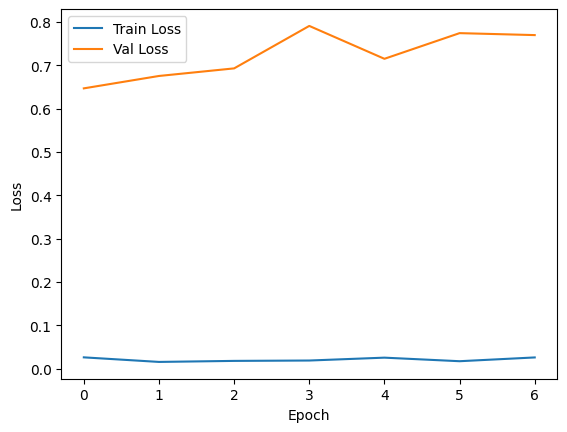

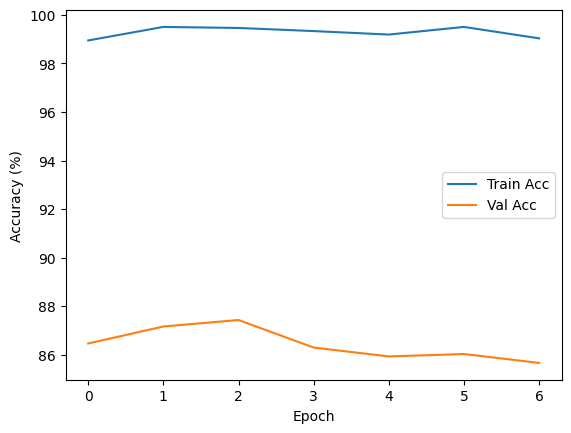

In [ ]:
import matplotlib.pyplot as plt

# Plot losses
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot accuracies
plt.figure()
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()


In [ ]:
#old loop no validation


# from tqdm import tqdm  # import tqdm

# for epoch in range(epochs):
#     total_epoch_loss = 0

#     # wrap train_loader with tqdm
#     for batch_features, batch_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
#         # move data to gpu
#         batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

#         # forward pass
#         outputs = vgg16(batch_features)

#         # calculate loss
#         loss = criterion(outputs, batch_labels)

#         # back pass
#         optimizer.zero_grad()
#         loss.backward()

#         # update grads
#         optimizer.step()

#         total_epoch_loss += loss.item()

#     avg_loss = total_epoch_loss / len(train_loader)
#     print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


In [ ]:
# --- Load best parameters from disk ---
vgg16.load_state_dict(torch.load("best_vgg16.pth", map_location=device))
vgg16 = vgg16.to(device)
vgg16.eval()

# --- Evaluate on test data ---
total, correct = 0, 0
with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = vgg16(batch_features)
        _, predicted = torch.max(outputs, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

accuracy = correct / total
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")


Accuracy: 0.8647 (86.47%)


In [ ]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import os

def evaluate_and_visualize_best(model_arch, best_model_path, dataset_path, device, n_samples=10, batch_size=32):
    """
    Load the best model from disk, evaluate accuracy on a dataset,
    and visualize random samples with predictions.

    Args:
        model_arch: PyTorch model architecture (uninitialized)
        best_model_path: path to the saved best model weights
        dataset_path: path to dataset folder (with class subfolders)
        device: "cuda" or "cpu"
        n_samples: number of random images to visualize
        batch_size: DataLoader batch size
    """
    # --- Load best model weights ---
    model_arch.load_state_dict(torch.load(best_model_path, map_location=device))
    model_arch = model_arch.to(device)
    model_arch.eval()

    # --- Prepare transforms and dataset ---
    input_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    test_dataset = RealVsGenDataset(dataset_path, transform=input_transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # --- Compute overall accuracy ---
    total, correct = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_arch(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total * 100
    print(f"Testing Accuracy: {acc:.2f}%")

    # --- Visualize random samples ---
    all_image_paths = []
    all_labels = []
    for class_idx, class_name in enumerate(test_dataset.classes):
        class_folder = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_folder):
            if img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                all_image_paths.append(os.path.join(class_folder, img_name))
                all_labels.append(class_idx)

    indices = random.sample(range(len(all_image_paths)), min(n_samples, len(all_image_paths)))
    for idx in indices:
        img_path = all_image_paths[idx]
        label = all_labels[idx]

        # Load original image for plotting
        img = Image.open(img_path).convert("RGB")

        # Transform for model input
        img_tensor = input_transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model_arch(img_tensor)
            prob = F.softmax(output, dim=1)
            pred_class = torch.argmax(prob, 1).item()

        # Plot original image with file name
        file_name = os.path.basename(img_path)
        plt.imshow(img)
        plt.title(f"{file_name}\nPredicted: {test_dataset.classes[pred_class]}, Actual: {test_dataset.classes[label]}")
        plt.axis("off")
        plt.show()


Testing Accuracy: 86.47%


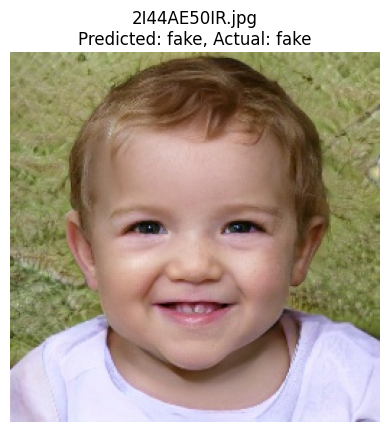

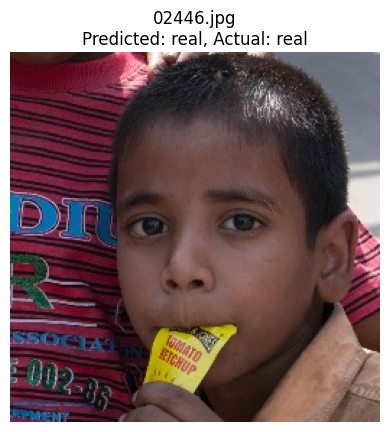

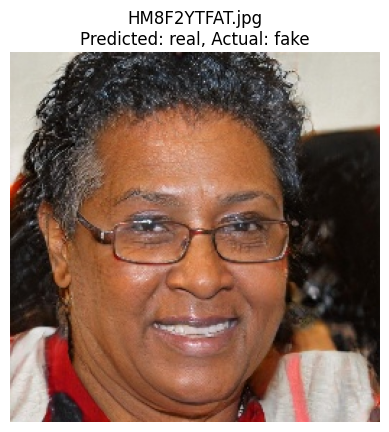

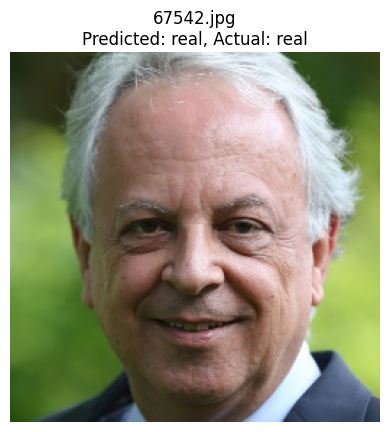

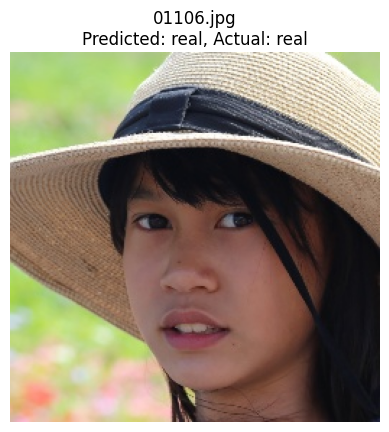

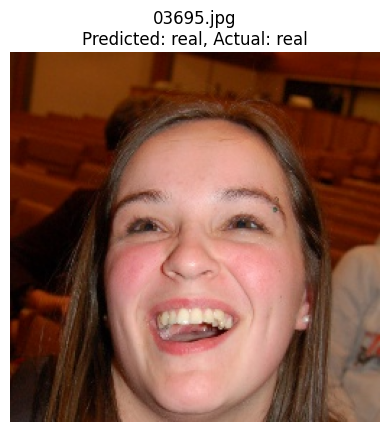

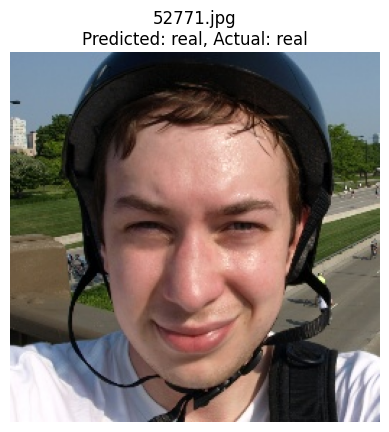

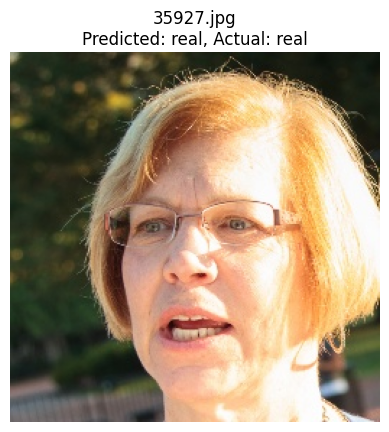

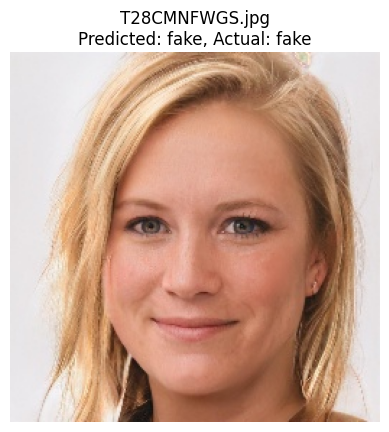

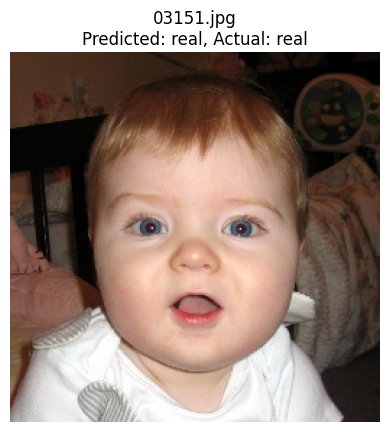

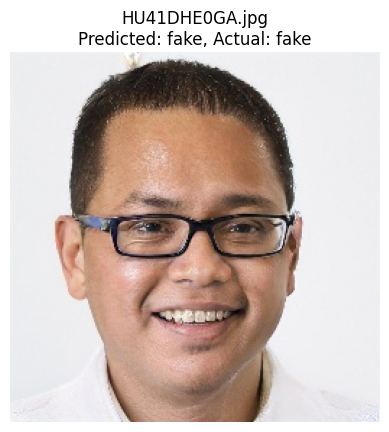

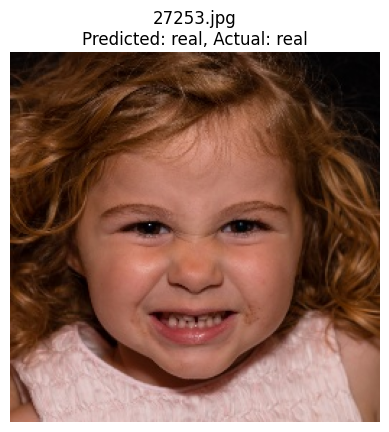

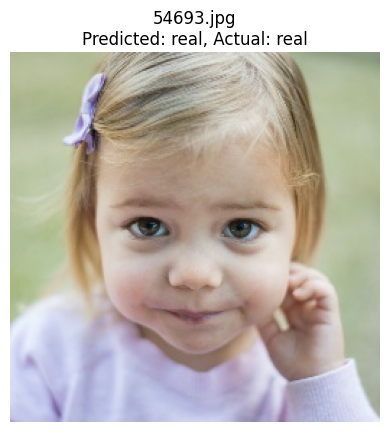

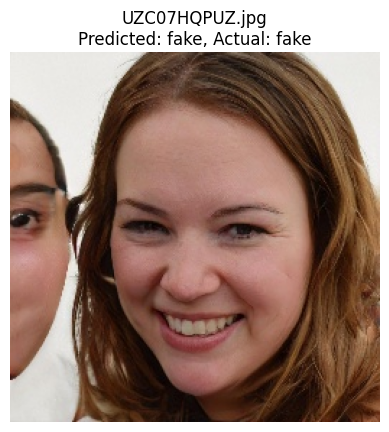

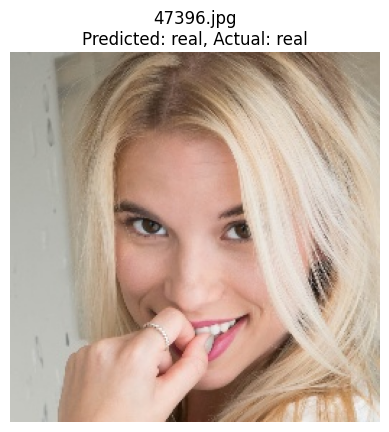

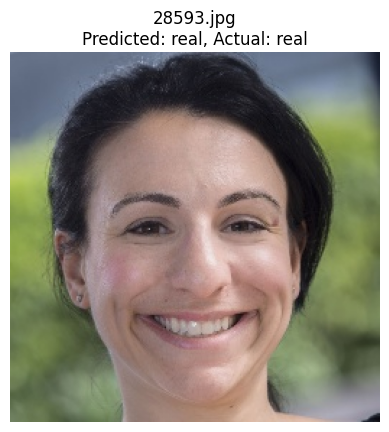

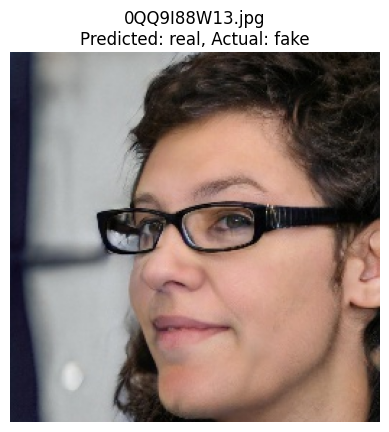

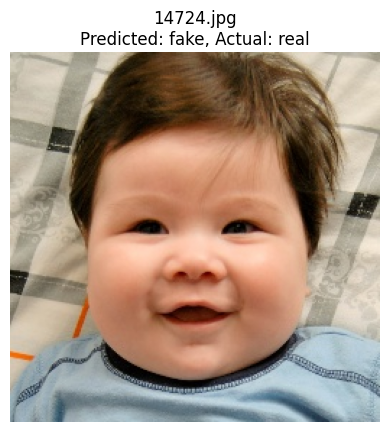

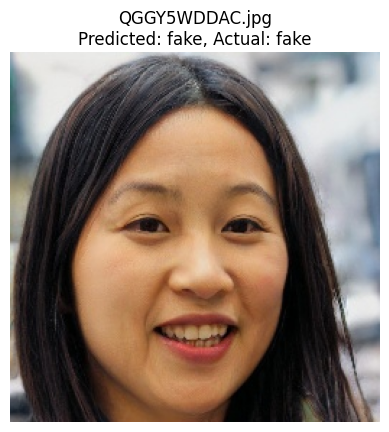

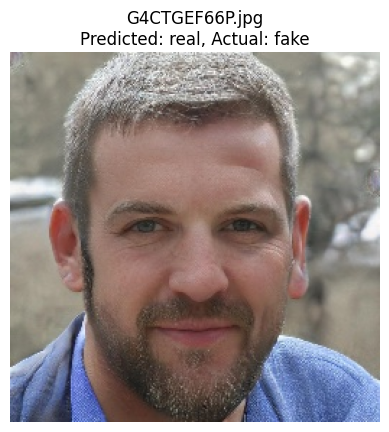

In [ ]:
evaluate_and_visualize_best(
    model_arch=vgg16,                     # architecture instance (unloaded weights)
    best_model_path="best_vgg16.pth",     # path to saved best weights
    dataset_path="/content/rvf10k/rvf10k/valid",
    device=device,
    n_samples=20
)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_metrics(model, dataloader, device):
    """
    Evaluate classification metrics: accuracy, precision, recall, F1-score, confusion matrix.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    return acc, precision, recall, f1, cm


In [ ]:
# Assuming best model is loaded
test_dataset = RealVsGenDataset("/content/rvf10k/rvf10k/valid", transform=custom_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

evaluate_metrics(vgg16, test_loader, device)


Accuracy : 0.8647
Precision: 0.8377
Recall   : 0.9047
F1-score : 0.8699
Confusion Matrix:
[[1237  263]
 [ 143 1357]]


(0.8646666666666667,
 0.8376543209876544,
 0.9046666666666666,
 0.8698717948717949,
 array([[1237,  263],
        [ 143, 1357]]))

In [ ]:
from google.colab import files


files.download("/content/vgg16_RealVsFake.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>